# Gaussian Process Regression

**Zhenwen Dai (2018-11-2)**

## Introduction

Gaussian process (GP) is a Bayesian non-parametric model used for various machine learning problems such as regression, classification. This notebook shows about how to use a Gaussian process regression model in MXFusion.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

## Toy data

We generate some synthetic data for our regression example. The data set is generate from a sine function with some additive Gaussian noise. 

In [2]:
import numpy as np
%matplotlib inline
from pylab import *

np.random.seed(0)
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05

The generated data are visualized as follows:

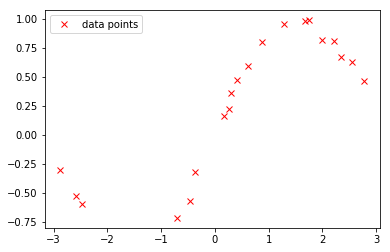

In [3]:
plot(X, Y, 'rx', label='data points')
_=legend()

## Gaussian process regression with Gaussian likelihood

Denote a set of input points $X \in \mathbb{R}^{N \times Q}$. A Gaussian process is often formulated as a multi-variate normal distribution conditioned on the inputs:
$$
p(F|X) = \mathcal{N}(F; 0, K),
$$
where $F \in \mathbb{R}^{N \times 1}$ is the corresponding output points of the Gaussian process and $K$ is the covariance matrix computed on the set of inputs according to a chosen kernel function $k(\cdot, \cdot)$.

For a regression problem, $F$ is often referred to as the noise-free output and we usually assume an additional probability distribution as the observation noise. In this case, we assume the noise distribution to be Gaussian:
$$
p(Y|F) = \mathcal{N}(Y; F, \sigma^2 \mathcal{I}),
$$
where $Y \in \mathbb{R}^{N \times 1}$ is the observed output and $\sigma^2$ is the variance of the Gaussian distribution.

The following code defines the above GP regression in MXFusion. First, we change the default data dtype to double precision to avoid any potential numerical issues.

In [4]:
from mxfusion.common import config
config.DEFAULT_DTYPE = 'float64'

In the code below, the variable ```Y``` is defined following the probabilistic module ```GPRegression```. A probabilistic module in MXFusion is a pre-built probabilistic model with dedicated inference algorithms for computing log-pdf and drawing samples. In this case, ```GPRegression``` defines the above GP regression model with a Gaussian likelihood. It understands that the log-likelihood after marginalizing $F$ is closed-form and exploits this property when computing log-pdf.

The model is defined by the input variable ```X``` with the shape ```(m.N, 1)```, where the value of ```m.N``` is discovered when data is given during inference. A positive noise variance variable ```m.noise_var``` is defined with the initial value to be 0.01. For GP, we define a RBF kernel with input dimensionality being one and initial value of variance and lengthscale to be one. We define the variable ```m.Y``` following the GP regression distribution with the above specified kernel, input variable and noise_variance.

In [5]:
from mxfusion import Model, Variable
from mxfusion.components.variables import PositiveTransformation
from mxfusion.components.distributions.gp.kernels import RBF
from mxfusion.modules.gp_modules import GPRegression

m = Model()
m.N = Variable()
m.X = Variable(shape=(m.N, 1))
m.noise_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=0.01)
m.kernel = RBF(input_dim=1, variance=1, lengthscale=1)
m.Y = GPRegression.define_variable(X=m.X, kernel=m.kernel, noise_var=m.noise_var, shape=(m.N, 1))

In the above model, we have not defined any prior distributions for any hyper-parameters. To use the model for regrssion, we typically do a maximum likelihood estimate for all the hyper-parameters conditioned on the input and output variable. In MXFusion, this is done by first creating an inference algorithm, which is ```MAP``` in this case, by specifying the observed variables. Then, we create an inference body for gradient optimization inference methods, which is called ```GradBasedInference```. The inference method is triggered by calling the ```run``` method, in which all the observed data are given as keyword arguments and any necessary configruation parameters are specified.

In [6]:
import mxnet as mx
from mxfusion.inference import GradBasedInference, MAP

infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]))
infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'), 
         max_iter=100, learning_rate=0.05, verbose=True)

Iteration 11 loss: -13.523289192527265
Iteration 21 loss: -16.077990179961076
Iteration 31 loss: -16.784414553096843
Iteration 41 loss: -16.820970924702017
Iteration 51 loss: -16.859865329532193
Iteration 61 loss: -16.895666914166453
Iteration 71 loss: -16.899409131167452
Iteration 81 loss: -16.901728290347176
Iteration 91 loss: -16.903122097339737
Iteration 100 loss: -16.903135093930537

All the inference outcomes are in the attribute ```params``` of the inference body. The inferred value of a parameter can be access by passing the reference of the queried parameter to the ```params``` attribute. For example, to get the value ```m.noise_var```, we can call ```inference.params[m.noise_var]```. The estimated parameters from the above experiment are as follows:

In [7]:
print('The estimated variance of the RBF kernel is %f.' % infr.params[m.kernel.variance].asscalar())
print('The estimated length scale of the RBF kernel is %f.' % infr.params[m.kernel.lengthscale].asscalar())
print('The estimated variance of the Gaussian likelihood is %f.' % infr.params[m.noise_var].asscalar())

The estimated variance of the RBF kernel is 0.616992.
The estimated length scale of the RBF kernel is 1.649073.
The estimated variance of the Gaussian likelihood is 0.002251.


We can compare the estimated values with the same model implemented in GPy. The estimated values from GPy are very close to the ones from MXFusion.

In [8]:
import GPy

m_gpy = GPy.models.GPRegression(X, Y, kernel=GPy.kern.RBF(1))
m_gpy.optimize()
print(m_gpy)


Name : GP regression
Objective : -16.903456670910902
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    0.6148038604494702  |      +ve      |        
  rbf.lengthscale          |    1.6500299722611123  |      +ve      |        
  Gaussian_noise.variance  |  0.002270049772204339  |      +ve      |        


## Prediction

The above section shows how to estimate the model hyper-parameters of a GP regression model. This is often referred to as training. After training, we are often interested in using the inferred model to predict on unseen inputs. The GP modules offers two types of predictions: predicting the mean and variance of the output variable or drawing samples from the predictive posterior distributions.

### Mean and variance of the posterior distribution

To estimate the mean and variance of the predictive posterior distribution, we use the inference algorithm ```ModulePredictionAlgorithm```, which takes the model, the observed variables and the target variables of prediction as input arguments. We use ```TransferInference``` as the inference body, which allows us to take the inference outcome from the previous inference. This is done by passing the inference parameters ```infr.params``` into the ```infr_params``` argument.

In [9]:
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.X], target_variables=[m.Y]), 
                              infr_params=infr.params)

To visualize the fitted model, we make predictions on 100 points evenly spanned from -5 to 5. We estimate the mean and variance of the noise-free output $F$.

In [10]:
xt = np.linspace(-5,5,100)[:, None]
res = infr_pred.run(X=mx.nd.array(xt, dtype='float64'))[0]
f_mean, f_var = res[0].asnumpy()[0], res[1].asnumpy()[0]

The resulting figure is shown as follows:

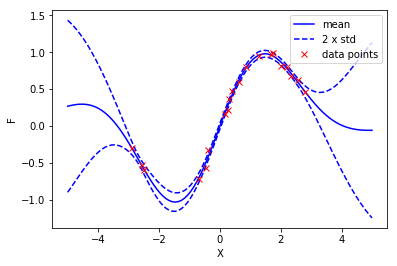

In [11]:
plot(xt, f_mean[:,0], 'b-', label='mean')
plot(xt, f_mean[:,0]-2*np.sqrt(f_var), 'b--', label='2 x std')
plot(xt, f_mean[:,0]+2*np.sqrt(f_var), 'b--')
plot(X, Y, 'rx', label='data points')
ylabel('F')
xlabel('X')
_=legend()

### Posterior samples of Gaussian process

Apart from getting the mean and variance at every location, we may need to draw samples from the posterior GP. As the output variables at different locations are correlated with each other, each sample gives us some idea of a potential function from the posterior GP distribution.

To draw samples from the posterior distribution, we need to change the prediction inference algorithm attached to the GP module. The default prediction function estimate the mean and variance of the output variable as shown above. We can attach another inference algorithm as the prediction algorithm. In the following code, we attach the ```GPRegressionSamplingPrediction``` algorithm as the prediction algorithm. The ```targets``` and ```conditionals``` arguments specify the target variables of the algorithm and the conditional variables of the algorithm. After spcifying a name in the ```alg_name``` argument such as ```gp_predict```, we can access this inference algorithm with the specified name like ```gp.gp_predict```. In following code, we set the ```diagonal_variance``` attribute to be ```False``` in order to draw samples from a full covariace matrix. To avoid numerical issue, we set a small jitter to help matrix inversion. Then, we create the inference body in the same way as the above example.

In [12]:
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
from mxfusion.modules.gp_modules.gp_regression import GPRegressionSamplingPrediction

gp = m.Y.factor
gp.attach_prediction_algorithms(targets=gp.output_names, conditionals=gp.input_names,
            algorithm=GPRegressionSamplingPrediction(
                gp._module_graph, gp._extra_graphs[0], [gp._module_graph.X]), 
            alg_name='gp_predict')
gp.gp_predict.diagonal_variance = False
gp.gp_predict.jitter = 1e-8
infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.X], target_variables=[m.Y], num_samples=5), 
                              infr_params=infr.params)

We draw five samples on the 100 evenly spanned input locations.

In [13]:
xt = np.linspace(-5,5,100)[:, None]
y_samples = infr_pred.run(X=mx.nd.array(xt, dtype='float64'))[0].asnumpy()

We visualize the individual samples each with a different color.

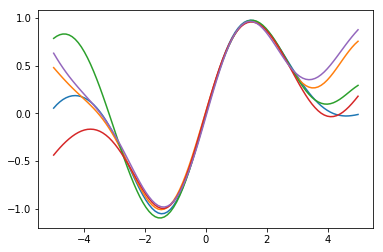

In [14]:
for i in range(y_samples.shape[0]):
    plot(xt, y_samples[i,:,0])

## Gaussian process with a mean function

TBA

## Variational sparse Gaussian process regression

TBA